# Reconhecimento de  MINST com Rede Neural Convolucional e TensorFlow


In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow as tf
import time

tf.reset_default_graph()


In [3]:
# verificar uso de GPU
if not tf.test.gpu_device_name():
    print('Nenhuma GPU encontrada.')
else:
    print('GPU usada: {}'.format(tf.test.gpu_device_name()))

GPU usada: /gpu:0


Sobre uso de GPU, rodado o treinamento com 1000 batches em alguns ambientes:
    - Notebook i5 rodando em CPU  :200s
    - Desktop i5 rodando CPU      :104s
    - Notebook rodando GPU (830m) : 44s
    - Cloud Floyd  GPU            :  9s
    
        

In [4]:
# Uma função para exibir uma imagem e a sua classificação
import matplotlib.pyplot as plt
%matplotlib inline

# Function for displaying a training image by it's index in the MNIST set
def display_digit(index,images, labels):
    label = labels[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = images[index].reshape([28,28])
    plt.title('Training data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()
    


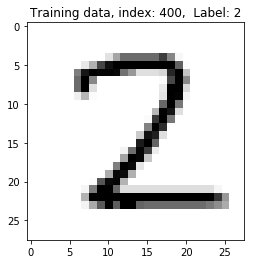

In [5]:
# Display the first (index 0) training image
display_digit(400,mnist.train.images,mnist.train.labels)

In [6]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial,name="WeightVariable")

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial,name="BiasVariable")

def conv2d(x, W,stride=1):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME',name="ConvOp")

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME',name="MaxPoolOp")



Criação dos Placeholders para os parâmetros de entrada, e Target:

In [7]:
x = tf.placeholder(tf.float32, [None, 784],name="InputVector")
x_image = tf.reshape(x, [-1, 28, 28, 1])

keep_prob = tf.placeholder(tf.float32, name="KeepProb")

y_ = tf.placeholder(tf.float32, [None, 10],name="Target")

Criando a rede Convolucional:
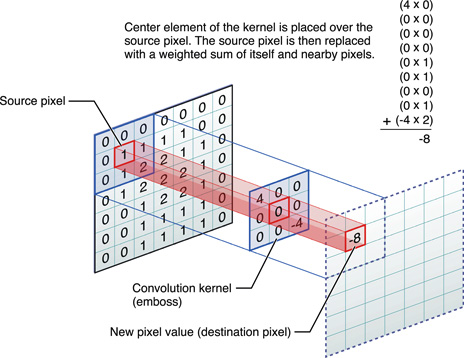

Duas camadas de Convolução 5x5, e MaxPool:
- a primeira convolução reduzindo a imagem de 28x28x1 para 28x28x32
- um MaxPool reduzindo para 14x14x32
- a segunda convolução  de 14x14x32 para 14x14x64
- um segundo MaxPool reduzindo para 7x7x64
- uma camada totalmente conectada, lendo o 7x7x64 (=3136) para 1024 
- e uma camdada final de 1024 para 10 classes.


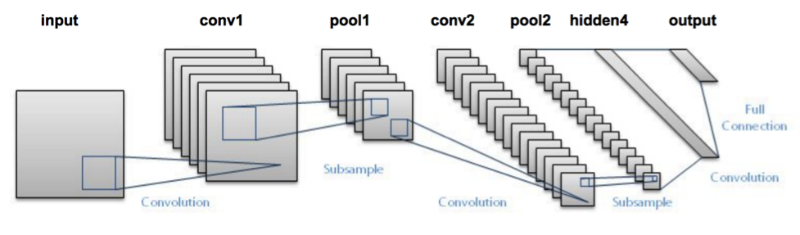




In [8]:

W_conv1 = weight_variable([5,5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y_softmax = tf.nn.softmax(y_conv, name = "SoftMaxOutput")

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(5e-5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name = "Accuracy")


Processo de treinamento da rede.

Roda 25.000 batches, cada um com 50 imagens, e salva o modelo treinado em "modelmnist.ckpt"

In [9]:
save_file = './modelmnist.ckpt'
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/1', sess.graph)
    start = time.time()
    for i in range(30000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: mnist.test.images[0:1000], 
                                                          y_: mnist.test.labels[0:1000], 
                                                          keep_prob: 1})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    elapsed_time = float(time.time() - start)
    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    print('Tempo de treinamento (s): %g' % elapsed_time)
    save_path = saver.save(sess, save_file)
    print('Modelo salvo em '+save_path)
    

step 0, training accuracy 0.097
step 100, training accuracy 0.751
step 200, training accuracy 0.836
step 300, training accuracy 0.87
step 400, training accuracy 0.884
step 500, training accuracy 0.904
step 600, training accuracy 0.911
step 700, training accuracy 0.925
step 800, training accuracy 0.924
step 900, training accuracy 0.928
step 1000, training accuracy 0.932
step 1100, training accuracy 0.939
step 1200, training accuracy 0.942
step 1300, training accuracy 0.947
step 1400, training accuracy 0.946
step 1500, training accuracy 0.947
step 1600, training accuracy 0.961
step 1700, training accuracy 0.955
step 1800, training accuracy 0.957
step 1900, training accuracy 0.955
step 2000, training accuracy 0.959
step 2100, training accuracy 0.96
step 2200, training accuracy 0.961
step 2300, training accuracy 0.963
step 2400, training accuracy 0.962
step 2500, training accuracy 0.965
step 2600, training accuracy 0.966
step 2700, training accuracy 0.963
step 2800, training accuracy 0.97


step 23200, training accuracy 0.991
step 23300, training accuracy 0.989
step 23400, training accuracy 0.989
step 23500, training accuracy 0.99
step 23600, training accuracy 0.988
step 23700, training accuracy 0.992
step 23800, training accuracy 0.988
step 23900, training accuracy 0.991
step 24000, training accuracy 0.988
step 24100, training accuracy 0.991
step 24200, training accuracy 0.99
step 24300, training accuracy 0.992
step 24400, training accuracy 0.993
step 24500, training accuracy 0.991
step 24600, training accuracy 0.991
step 24700, training accuracy 0.989
step 24800, training accuracy 0.986
step 24900, training accuracy 0.985
step 25000, training accuracy 0.989
step 25100, training accuracy 0.988
step 25200, training accuracy 0.992
step 25300, training accuracy 0.99
step 25400, training accuracy 0.99
step 25500, training accuracy 0.989
step 25600, training accuracy 0.99
step 25700, training accuracy 0.99
step 25800, training accuracy 0.99
step 25900, training accuracy 0.99


Separando agora em uma segunda fase, para permitir desacoplar o uso da rede treinada do treinamento, faz-se a leitura do modelo salvo.
Com isso, é possível treinar a rede uma única vez, e reusá-la em futuras sessões, somente lendo o checkpoint.

In [10]:
save_file = './modelmnist.ckpt'
 
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(save_file + '.meta')
    loader.restore(sess, save_file)

    x = loaded_graph.get_tensor_by_name('InputVector:0')
    keep_prob = loaded_graph.get_tensor_by_name('KeepProb:0')
    accuracy = loaded_graph.get_tensor_by_name('Accuracy:0')
    y_softmax = loaded_graph.get_tensor_by_name('SoftMaxOutput:0')
    y_ = loaded_graph.get_tensor_by_name('Target:0')
    
    (acc, predictions) = sess.run([accuracy,y_softmax],feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    
    print('test accuracy %g' % acc)
    


INFO:tensorflow:Restoring parameters from ./modelmnist.ckpt
test accuracy 0.9916


In [11]:
def getErrorsIndexes(predictionsValues, correctValues, images):
    correct = correctValues.argmax(axis=1)
    predictions = predictionsValues.argmax(axis=1)
    errors = correct-predictions
    indexErrors = errors.nonzero()[0]
    return indexErrors


E aqui, uma visualização das  imagens reconhecidas erroneamente.

Interessante observer, que apesar de mostrar o numero errado, na maioria das vezes quando o número ainda e claro, a opção correta estava muito próxima.

In [12]:
indexErrors = getErrorsIndexes(predictions,mnist.test.labels,mnist.test.images)
num_to_print = 15
print('Indices dos %g primeiros numeros reconhecidos erroneamente: ' % num_to_print)
print(indexErrors[0:num_to_print])
print('Total de reconhecimentos errados: %g ' % len(indexErrors))


Indices dos 15 primeiros numeros reconhecidos erroneamente: 
[  18  247  321  445  449  582  583  947 1014 1039 1112 1226 1232 1242 1247]
Total de reconhecimentos errados: 84 


In [13]:
import numpy as np
def display_image_predictions(index, predictions, labels,features):
    print("Indice Imagem: %d " % index)
    rounded =  [ round(v.item(),2) for v in predictions[index]]
    
    image = features[index].reshape([28,28])
    label = labels[index].argmax(axis=0)
    predictedNumber = predictions[index].argmax(axis=0)
    pred_values = predictions[index]

    fig, axies = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions:  '+str(rounded), fontsize=14, y=1.1)
    
    n_predictions = 10
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    
    correct_name = "Digit:"+str(label)+" \nPredicted:"+str(predictedNumber)

    axies[0].imshow(image, cmap='gray_r')
    axies[0].set_title(correct_name)
    axies[0].set_axis_off()

    axies[1].barh(ind + margin, pred_values, width)
    axies[1].set_yticks(ind + margin)
    axies[1].set_yticklabels(ind)
    axies[1].set_xticks([0, 0.5, 1.0])
    plt.show()

Indice Imagem: 445 


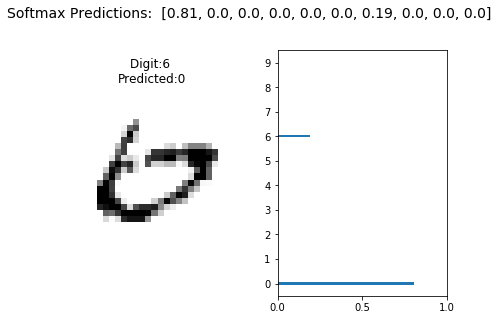

Indice Imagem: 947 


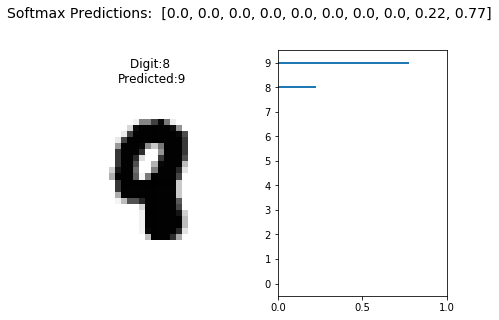

Indice Imagem: 1112 


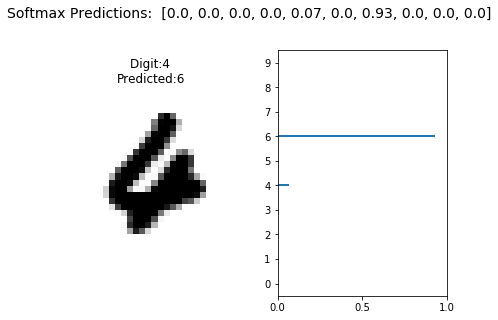

Indice Imagem: 1393 


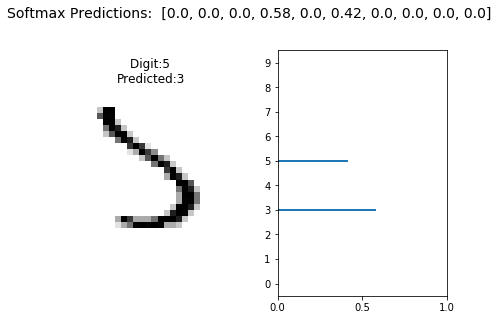

Indice Imagem: 1530 


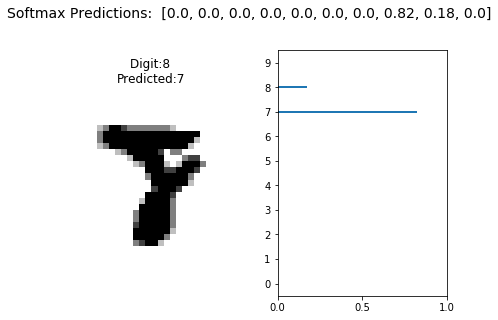

In [16]:
display_image_predictions(indexErrors[3],predictions,mnist.test.labels,mnist.test.images)
display_image_predictions(indexErrors[7],predictions,mnist.test.labels,mnist.test.images)
display_image_predictions(indexErrors[10],predictions,mnist.test.labels,mnist.test.images)
display_image_predictions(indexErrors[15],predictions,mnist.test.labels,mnist.test.images)
display_image_predictions(indexErrors[17],predictions,mnist.test.labels,mnist.test.images)


Indice Imagem: 158 


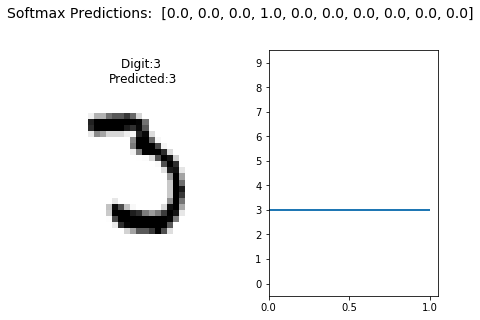

In [15]:
display_image_predictions(158,predictions,mnist.test.labels,mnist.test.images)